In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kidney_disease.csv to kidney_disease (1).csv


In [ ]:
# Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
)
warnings.filterwarnings('ignore')

In [ ]:
# Step 3: Load and preview dataset
df = pd.read_csv(next(iter(uploaded)))
print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (400, 26)
   id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  

[5 rows x 26 columns]


In [ ]:
# Step 4: Missing-value summary
print("\nMissing values per column:")
print(df.isin(['?']).sum() + df.isnull().sum())


Missing values per column:
id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64


In [ ]:
# Step 5: Clean data
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Drop identifier column if present
df.drop(columns=['id'], errors='ignore', inplace=True)

# Define numeric and categorical columns
num_cols = ['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
cat_cols = [c for c in df.columns if c not in num_cols + ['classification']]

# Convert numeric columns and impute median
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    median = df[col].median()
    print(f"Imputing {col}: median={median}")
    df[col].fillna(median, inplace=True)

# Impute categorical columns by overall mode
for col in cat_cols:
    mode_val = df[col].mode().iloc[0]
    print(f"Imputing {col}: mode='{mode_val}'")
    df[col].fillna(mode_val, inplace=True)

Imputing age: median=55.0
Imputing bp: median=80.0
Imputing sg: median=1.02
Imputing al: median=0.0
Imputing su: median=0.0
Imputing bgr: median=121.0
Imputing bu: median=42.0
Imputing sc: median=1.3
Imputing sod: median=138.0
Imputing pot: median=4.4
Imputing hemo: median=12.649999999999999
Imputing pcv: median=40.0
Imputing wc: median=8000.0
Imputing rc: median=4.8
Imputing rbc: mode='normal'
Imputing pc: mode='normal'
Imputing pcc: mode='notpresent'
Imputing ba: mode='notpresent'
Imputing htn: mode='no'
Imputing dm: mode='no'
Imputing cad: mode='no'
Imputing appet: mode='good'
Imputing pe: mode='no'
Imputing ane: mode='no'


In [ ]:
# Step 6: Encode target label
le = LabelEncoder()
df['classification'] = le.fit_transform(df['classification'].astype(str).str.strip())
print("\nLabel encoding mapping:", dict(zip(le.classes_, le.transform(le.classes_))))



Label encoding mapping: {'0': np.int64(0), '1': np.int64(1)}


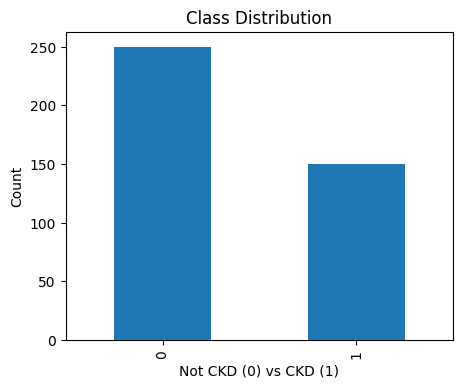

In [ ]:
# Step 7: Exploratory plots and correlation heatmap
plt.figure(figsize=(5,4))
df['classification'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Not CKD (0) vs CKD (1)')
plt.ylabel('Count')
plt.show()

<Figure size 500x400 with 0 Axes>

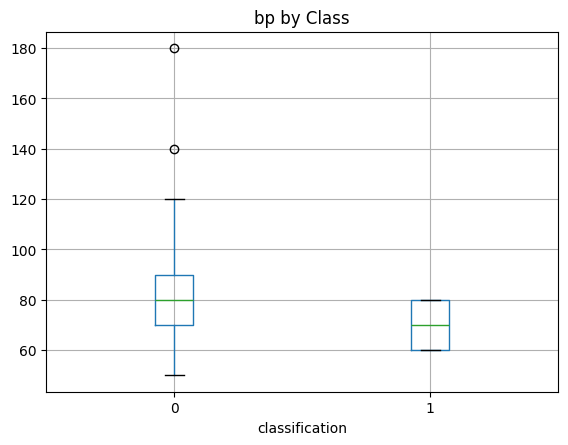

In [ ]:
# Boxplots for key features by class
for feature in ['bp']:
    plt.figure(figsize=(5,4))
    df.boxplot(column=feature, by='classification')
    plt.title(f'{feature} by Class')
    plt.suptitle('')
    plt.show()

<Figure size 500x400 with 0 Axes>

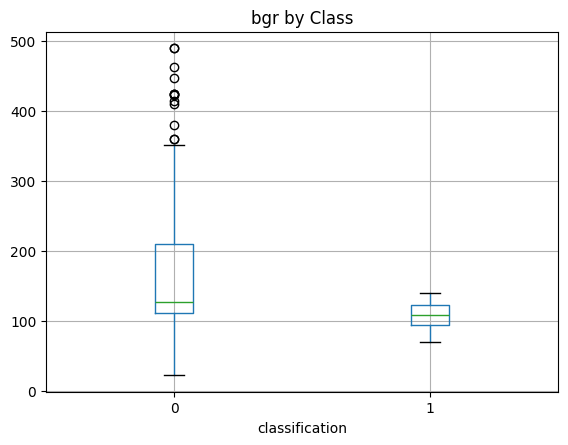

In [ ]:
for feature in ['bgr']:
    plt.figure(figsize=(5,4))
    df.boxplot(column=feature, by='classification')
    plt.title(f'{feature} by Class')
    plt.suptitle('')
    plt.show()

<Figure size 500x400 with 0 Axes>

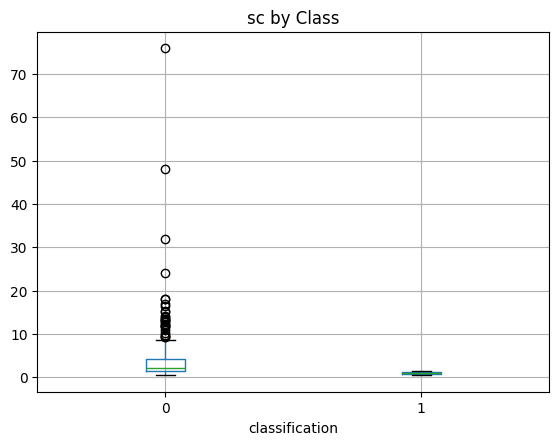

In [ ]:
for feature in ['sc']:
    plt.figure(figsize=(5,4))
    df.boxplot(column=feature, by='classification')
    plt.title(f'{feature} by Class')
    plt.suptitle('')
    plt.show()

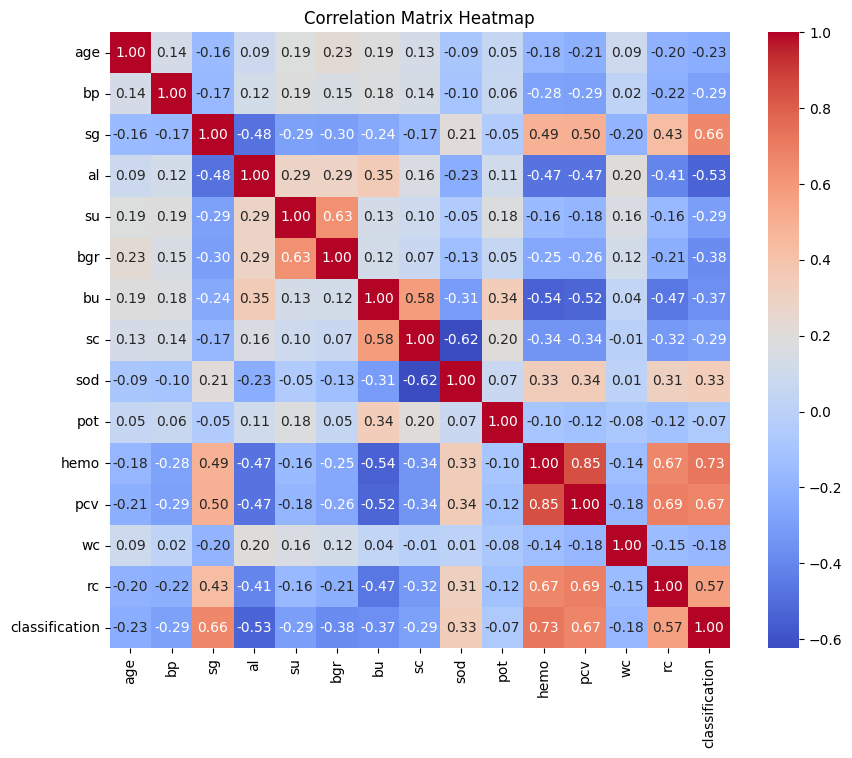

In [ ]:
# Correlation heatmap for numeric features
import seaborn as sns
plt.figure(figsize=(10,8))
corr = df[num_cols + ['classification']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()



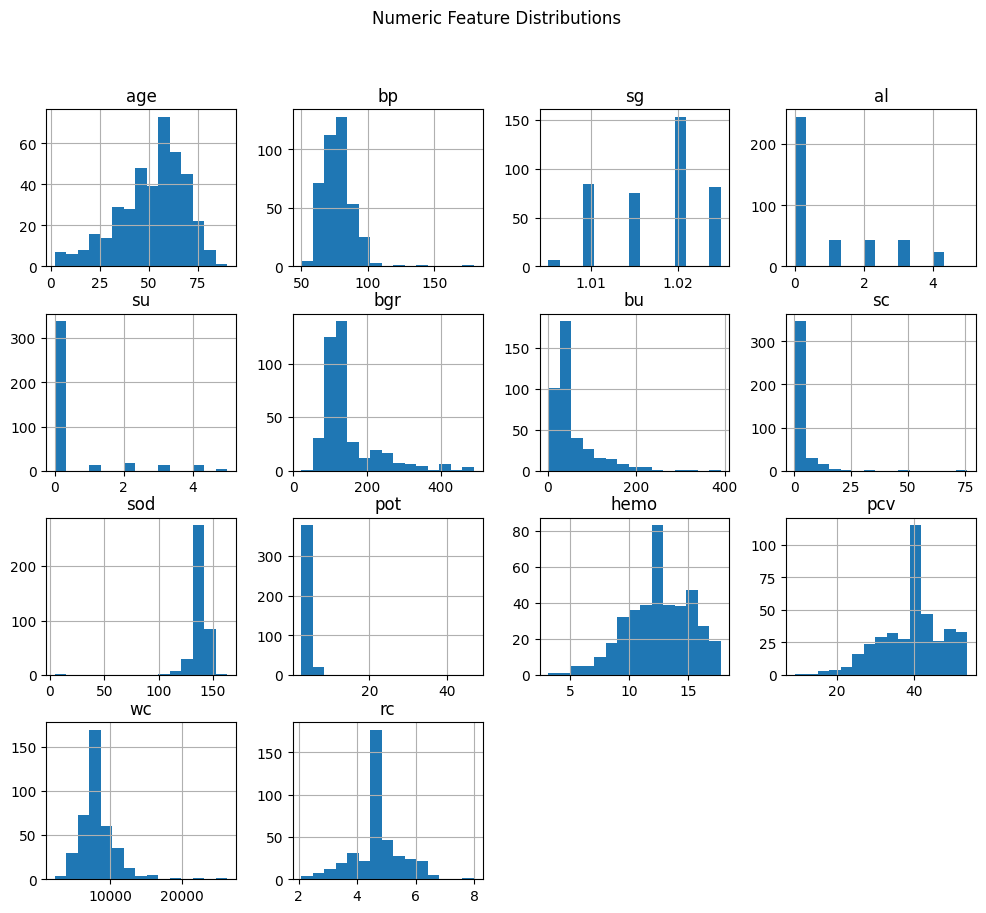

In [ ]:
# Histogram distributions of numeric features
df[num_cols].hist(bins=15, figsize=(12,10))
plt.suptitle('Numeric Feature Distributions')
plt.show()

In [ ]:
# Step 8: Split into train and test sets
X = df.drop('classification', axis=1)
y = df['classification']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Step 9: Preprocessing pipelines
numeric_feats = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_feats = X.select_dtypes(include=['object']).columns.tolist()
num_pipeline = Pipeline([('scaler', StandardScaler())])
cat_pipeline = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_feats),
    ('cat', cat_pipeline, categorical_feats)
])

# Evaluation helper
def eval_model(pipe, name):
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp)
    print(f"\n--- {name} ---")
    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, Specificity: {spec:.3f}")
    if y_prob is not None:
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")
    ConfusionMatrixDisplay(cm).plot()
    plt.show()



--- Logistic Regression ---
Accuracy: 0.988, Precision: 0.968, Recall: 1.000, F1: 0.984, Specificity: 0.980
ROC AUC: 0.999


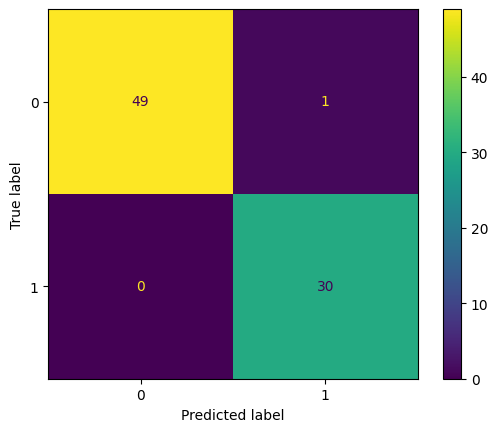

In [ ]:
# Step 10: Logistic Regression
pipe_lr = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
pipe_lr.fit(X_train, y_train)
eval_model(pipe_lr, 'Logistic Regression')


Best k by CV: 2 (Accuracy=0.975)

--- KNN (k=2) ---
Accuracy: 0.963, Precision: 0.966, Recall: 0.933, F1: 0.949, Specificity: 0.980
ROC AUC: 0.989


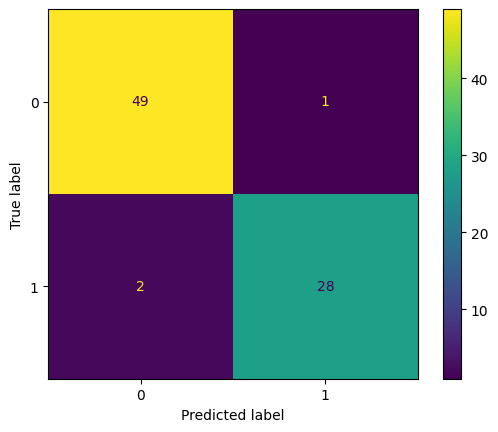

In [ ]:
# Step 11: KNN with cross-validation for k
cv_scores = []
for k in range(1, 21):
    pipe_knn = Pipeline([
        ('prep', preprocessor),
        ('clf', KNeighborsClassifier(n_neighbors=k))
    ])
    scores = cross_val_score(pipe_knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
best_k = int(np.argmax(cv_scores) + 1)
print(f"Best k by CV: {best_k} (Accuracy={cv_scores[best_k-1]:.3f})")
pipe_knn = Pipeline([
    ('prep', preprocessor),
    ('clf', KNeighborsClassifier(n_neighbors=best_k))
])
pipe_knn.fit(X_train, y_train)
eval_model(pipe_knn, f'KNN (k={best_k})')


Best SVM params: {'clf__C': 0.1, 'clf__kernel': 'linear'}

--- SVM (GridSearch) ---
Accuracy: 0.988, Precision: 0.968, Recall: 1.000, F1: 0.984, Specificity: 0.980
ROC AUC: 1.000


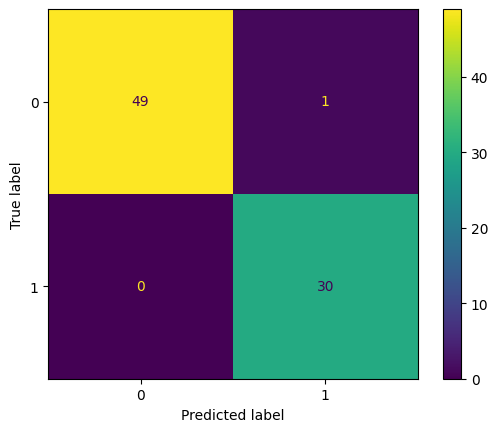

In [ ]:
# Step 12: SVM grid search
gs_svm = GridSearchCV(
    Pipeline([('prep', preprocessor), ('clf', SVC(probability=True, class_weight='balanced'))]),
    {'clf__C': [0.1, 1, 10], 'clf__kernel': ['rbf', 'linear']},
    cv=5, scoring='f1', n_jobs=-1
)
gs_svm.fit(X_train, y_train)
print("Best SVM params:", gs_svm.best_params_)
best_svm = gs_svm.best_estimator_
eval_model(best_svm, 'SVM (GridSearch)')


Best RF params: {'clf__max_depth': None, 'clf__n_estimators': 100}

--- Random Forest (GridSearch) ---
Accuracy: 0.975, Precision: 1.000, Recall: 0.933, F1: 0.966, Specificity: 1.000
ROC AUC: 0.999


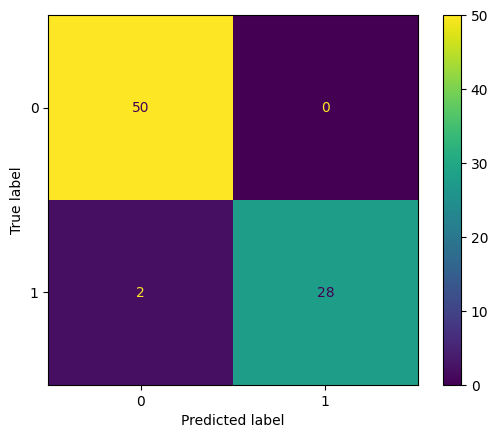


Top 10 feature importances:
pcv        0.221656
hemo       0.193714
sg         0.103100
sc         0.092394
rc         0.067495
al         0.059334
htn_yes    0.040823
dm_no      0.038690
htn_no     0.029308
bu         0.025069
dtype: float64


In [ ]:
# Step 13: Random Forest tuning
gs_rf = GridSearchCV(
    Pipeline([('prep', preprocessor), ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))]),
    {'clf__n_estimators': [100, 200], 'clf__max_depth': [None, 10, 20]},
    cv=5, scoring='f1', n_jobs=-1
)
gs_rf.fit(X_train, y_train)
print("Best RF params:", gs_rf.best_params_)
best_rf = gs_rf.best_estimator_
eval_model(best_rf, 'Random Forest (GridSearch)')

# Feature importance
importances = best_rf.named_steps['clf'].feature_importances_
cat_features = best_rf.named_steps['prep'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_feats)
feature_names = numeric_feats + list(cat_features)
feat_imp = pd.Series(importances, index=feature_names).nlargest(10)
print("\nTop 10 feature importances:")
print(feat_imp)

In [ ]:
# Step 14: Save pipeline and encoder
import joblib
joblib.dump({'pipeline': best_rf, 'label_encoder': le}, 'ckd_model_bundle.pkl')
print("Saved bundled pipeline and encoder to 'ckd_model_bundle.pkl'")

Saved bundled pipeline and encoder to 'ckd_model_bundle.pkl'
